In [1]:
# this enable automatic reloading of libraries
%load_ext autoreload
%autoreload 2
from clib.bellhop import *
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

# Celerity profile selection

In [2]:
s = bellhop({'mediterrannee': './SSP_4profils.mat'},name='cognac_cmap',rmax=100.)
#s.params

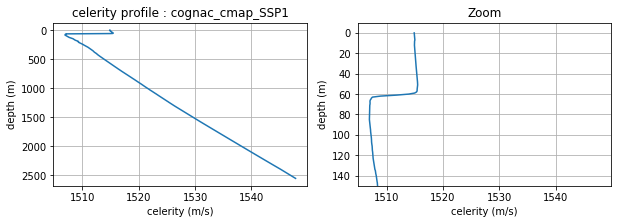

In [3]:
issp=0   # sound speed profile number
s.plotssp('mediterrannee', Issp=issp)

---
# Bellhop arrival calculations for this profile

- *Bathymetry* : flat bottom at 2000 m depth

- *Source* : one source at 100m depth at range 0km

- *Receivers* : **Depth** : from 0 to 500m depth    /    **Range** : from 0 to 10 km 

In [4]:
#Arr, Pos = s.read_arrivals_asc ('files_arr/cognac_2000m_test_A_full.arr', Narrmx = 15)
Arr, Pos = s.load_dict('Dictio', 'Arr1'), s.load_dict('Dictio', 'Pos1')

In [5]:
Nsd = np.shape(Pos['s']['depth'])[0]
Nrd = np.shape(Pos['r']['depth'])[0]
Nrr = np.shape(Pos['r']['range'])[0]
print('Number of source depths   : Nsd = ', Nsd)
print('Number of receiver depths : Nrd = ', Nrd)
print('Number of receiver ranges : Nrr = ', Nrr)
print('\nTotal number of receivers : ', Nrd*Nrr)

Number of source depths   : Nsd =  1
Number of receiver depths : Nrd =  501
Number of receiver ranges : Nrr =  10001

Total number of receivers :  5010501


---
### A - Example of arrivals on 1 receiver

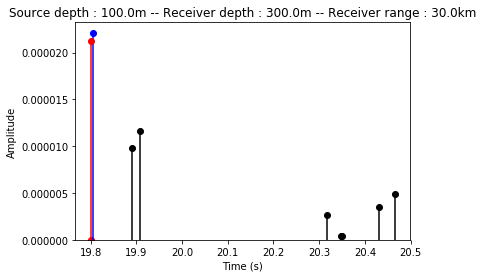

In [6]:
isd = 0       # choice of source depth (from 0 to Nsd-1)  
ird = 300     # choice of receiver depth (from 0 to Nrd-1)
irr = 3000    # choice of receiver range (from 0 to Nrr-1)

s.plotarr(Arr, Pos, irr, ird, isd)
#plt.xlim (xmin = 1.652, xmax = 1.6525)

---
### B - From amplitude to received level

- We choose to work with **coherent TL** --> **modulus of complex pressure** is calculated (and not only real part of it).  

In [7]:
Narr = int(Arr['Narr'][irr,ird,isd])  # number of arrivals
A = Arr['A'][irr, :Narr, ird, isd]    # amplitude
TL = -20.0 * np.log10 (abs(A))        # transmission loss (dB)

print('Amplitude : \n', A)
print('\nTL (in dB) : \n', TL)

Amplitude : 
 [-4.91701365e-06  9.77235907e-06 -1.15907815e-05 -4.35306885e-07
  9.08574896e-22 -2.21201426e-05  3.54570822e-06  2.12531831e-05
 -4.35124358e-07  2.69460716e-06]

TL (in dB) : 
 [106.16597173 100.20001168  98.71774561 127.22408928 420.83278534
  93.10424155 109.00594011  93.45152032 127.2277321  111.39009081]


---
- To work with **received level**, we use the sonar equation : 

    **RL  = SL - TL - NL + DI + PG**

In [8]:
SL = 185                 # Souce level (dB)
NL = 81.7                # Noise level (dB)
DI = 0                   # Directivity index (dB)
B = 200                  # Bandwidth (Hz)
T = 1                    # Transmitted signal duration (s)
PG = 10.0*np.log10(B*T)  # Processing gain (dB)

---
<img src='images/arrivals_petit.png' alt='Drawing' align='right' /> 

# Detection methods


---
- **Maximum amplitude** : the arrival with the biggest amplitude is selected.  


---
- **Detection treshold** : the first arrival (in time) to have a greater amplitude   
 than the detection treshold is selected.

In [9]:
seuil_d = 10.            # Detection treshold (dB)

---
# Equivalent celerity 
We calculate equivalent celerity by 3 different methods :

<img src='images/celerite_eq_petit.png' alt='Drawing' align='right' />

### A - First method : equivalent distance

__*Known*__: 
- Travel time from source to receiver for the detected ray. 
  
  
__*Calculated*__ : 
- Real distance travelled by each detected ray, for each receiver --> real celerity 
- Source-receiver distance, for each receiver --> **equivalent celerity**  




<img src='images/celerity_profile_petit.png' alt='Drawing' align='right' />

### B - Second method : mean celerity 


__*Known*__: 
- Celerity profile of the area  
  
__*Calculated*__: 
- **Equivalent celerity** = mean celerity between source depth and receiver depth 

<img src='images/reg_lin.png' alt='Drawing' align='right' style='width: 420px;'/>

### C - Third method : linear regression 

__*Known*__: 
- Travel time from source to receiver.
- Distance source-receiver
  
__*Calculated*__: 
- **Equivalent celerity** = linear regression result (slope)

---
# Time, distance and celerity calculations

### A - Outputs from notebook "equivalent celerity"

In [10]:
#resolution choice 
dstep = 100#10          # depth step (here 10m)
rstep = 2000#100        # range step (here 1km)

In [11]:
Tarr_A = np.load('NPY_cel/Tarr_A1.npy')
Dist_real_A = np.load('NPY_cel/Dist_real_A1.npy')
Angle_diff_A = np.load('NPY_cel/Angle_diff_A1.npy')
Same_nbref_A = np.load('NPY_cel/Same_nbref_A1.npy')

Tarr_T = np.load('NPY_cel/Tarr_T1.npy')
Dist_real_T = np.load('NPY_cel/Dist_real_T1.npy')
Angle_diff_T = np.load('NPY_cel/Angle_diff_T1.npy')
Same_nbref_T = np.load('NPY_cel/Same_nbref_T1.npy')

Dist_eq = np.load('NPY_cel/Dist_eq1.npy')
C_mean = np.load('NPY_cel/C_mean1.npy')

### B - Filters to apply on real celerity

In [85]:
### Filter 1 : max difference accepted between ray angles from A and E  

seuil = 0.5   # accepted treshold (°)
Filter1_T = np.zeros_like(Angle_diff_T)
Filter1_A = np.zeros_like(Angle_diff_T)
Filter1_T[:] = np.NaN
Filter1_A[:] = np.NaN
for i in range(np.shape(Angle_diff_T)[0]):
    for j in range(np.shape(Angle_diff_T)[1]):
        if Angle_diff_T [i,j,0] < seuil :
            Filter1_T [i,j,0] = 1
        if Angle_diff_A [i,j,0] < seuil :
            Filter1_A [i,j,0] = 1
        

In [86]:
### Filtre 2 : same number of top and bottom reflections or not 
Filtre2_T = Same_nbref_T
Filtre2_A = Same_nbref_A
Filtre2_T[np.where(Filtre2_T==0)]=np.NaN
Filtre2_A[np.where(Filtre2_A==0)]=np.NaN

### C - Real and equivalent celerities

In [87]:
# Real celerity (from real travelled distance)
C_real_T = ( Dist_real_T / Tarr_T ) * Filtre1_T * Filtre2_T
C_real_A = ( Dist_real_A / Tarr_A ) * Filtre1_A * Filtre2_A

In [88]:
# Method 1 (eq distance)
C_eq_T = Dist_eq / Tarr_T
C_eq_A = Dist_eq / Tarr_A
print('DETECTION TRESHOLD')
print('min (Ceq)  : %.1fm/s' %np.min(C_eq_T[~np.isnan(C_eq_T)]))
print('max (Ceq)  : %.1fm/s' %np.max(C_eq_T[~np.isnan(C_eq_T)]))
print('mean (Ceq) : %.1fm/s' %np.mean(C_eq_T[~np.isnan(C_eq_T)]))
print('\nMAXIMUM AMPLITUDE')
print('min (Ceq)  : %.1fm/s' %np.min(C_eq_A[~np.isnan(C_eq_A)]))
print('max (Ceq)  : %.1fm/s' %np.max(C_eq_A[~np.isnan(C_eq_A)]))
print('mean (Ceq) : %.1fm/s' %np.mean(C_eq_A[~np.isnan(C_eq_A)]))

DETECTION TRESHOLD
min (Ceq)  : 1202.9m/s
max (Ceq)  : 1518.7m/s
mean (Ceq) : 1502.3m/s

MAXIMUM AMPLITUDE
min (Ceq)  : 1045.5m/s
max (Ceq)  : 1518.7m/s
mean (Ceq) : 1487.8m/s


In [89]:
# Method 2 (mean celerity) : C_mean
print('min (mean celerity)  : %.1fm/s' %np.min(C_mean[~np.isnan(C_mean)]))
print('max (mean celerity)  : %.1fm/s' %np.max(C_mean[~np.isnan(C_mean)]))
print('mean (mean celerity) : %.1fm/s' %np.mean(C_mean[~np.isnan(C_mean)]))

min (mean celerity)  : 1507.1m/s
max (mean celerity)  : 1512.0m/s
mean (mean celerity) : 1509.2m/s


In [90]:
# Method 3
x = Tarr_T.flatten()                                  # time of arrival
#y = Dist_real_T.flatten()/1000.                       # real travelled distance
y = Dist_eq.flatten()/1000.                            # distance source-receiver
res = np.polyfit(x[~np.isnan(x)],y[~np.isnan(x)],1)    # res[0] = slope
C_reg_T = res[0]*1000.                                 # equivalent celerity

xA = Tarr_A.flatten()      
#yA = Dist_real_A.flatten()/1000.
yA = Dist_eq.flatten()/1000.
resA = np.polyfit(xA[~np.isnan(xA)],yA[~np.isnan(xA)],1) 
C_reg_A = resA[0]*1000.   

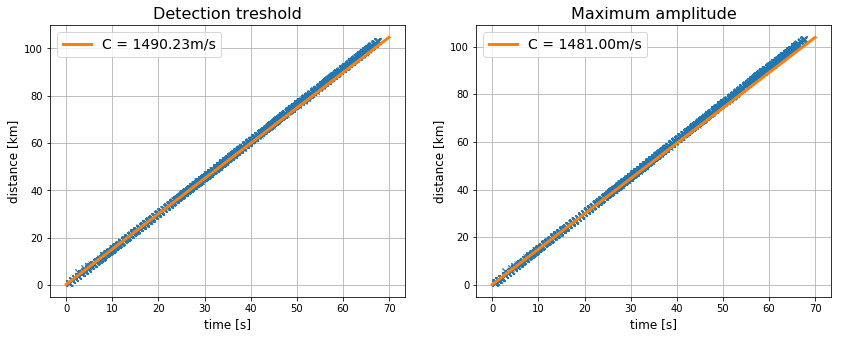

In [92]:
# Plot
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(Tarr_T.flatten(), Dist_real_T.flatten()/1000.,'x')
xreg = np.array([0,20,40,60,70])
yreg = res[0]*xreg + res[1]
plt.plot(xreg, yreg, label = 'C = %.2fm/s' %(res[0]*1000.), linewidth=3)
plt.title('Detection treshold',fontsize=16)
plt.xlabel('time [s]',fontsize=12)
plt.ylabel('distance [km]',fontsize=12)
plt.grid()
plt.legend(fontsize=14)
#plt.xlim([24,26]), plt.ylim([36,41])

plt.subplot(122)
plt.plot(Tarr_T.flatten(), Dist_real_T.flatten()/1000.,'x')
yreg = resA[0]*xreg + resA[1]
plt.plot(xreg, yreg, label = 'C = %.2fm/s' %(resA[0]*1000.), linewidth=3)
plt.title('Maximum amplitude',fontsize=16)
plt.xlabel('time [s]',fontsize=12)
plt.ylabel('distance [km]',fontsize=12)
plt.grid()
plt.legend(fontsize=14)
plt.show()


---
# Results :  Difference between real and equivalent celerities

In [93]:
#detection treshold
DC1_T = C_real_T - C_eq_T   #method 1
DC2_T = C_real_T - C_mean   #method 2
DC3_T = C_real_T - C_reg_T   #method 3 

#maximum amplitude
DC1_A = C_real_A - C_eq_A   #method 1
DC2_A = C_real_A - C_mean   #method 2
DC3_A = C_real_A - C_reg_A   #method 3 

In [94]:
isd = 0                 # source number (only 1 source here)
R = Pos['r']['range']
Z = Pos['r']['depth']
dstep = 10          # depth step (here 10m)
rstep = 100        # range step (here 1km)
r = R [::rstep]
z = Z [::dstep]

### A - Detection treshold

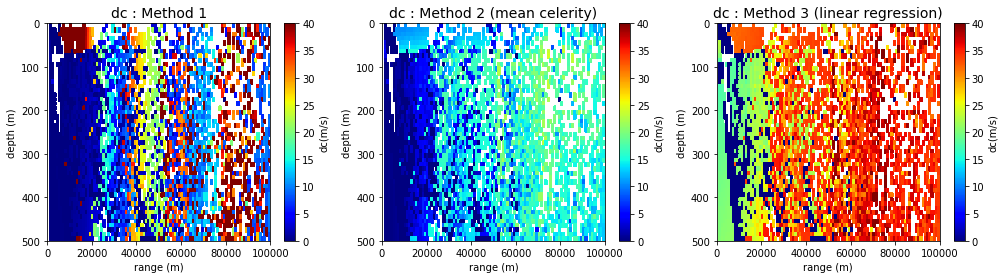

In [95]:
plt.figure(figsize=(17,4))
plt.subplot(131)
plt.pcolormesh(r, z, DC1_T[:,:,isd].T, cmap='jet')
plt.title ('dc : Method 1', fontsize=14)
plt.xlabel("range (m)")
plt.ylabel("depth (m)")
cbar = plt.colorbar()
cbar.set_label("dc(m/s)")
plt.clim ([0,40])
plt.gca().invert_yaxis()

plt.subplot(132)
plt.pcolormesh(r, z, DC2_T[:,:,isd].T, cmap='jet')
plt.title ('dc : Method 2 (mean celerity)', fontsize=14)
plt.xlabel("range (m)")
plt.ylabel("depth (m)")
cbar = plt.colorbar()
cbar.set_label("dc(m/s)")
plt.clim ([0,40])
plt.gca().invert_yaxis()

plt.subplot(133)
plt.pcolormesh(r, z, DC3_T[:,:,isd].T, cmap='jet')
plt.title ('dc : Method 3 (linear regression)', fontsize=14)
plt.xlabel("range (m)")
plt.ylabel("depth (m)")
cbar = plt.colorbar()
cbar.set_label("dc(m/s)")
plt.clim ([0,40])
plt.gca().invert_yaxis()

### B - Maximum amplitude

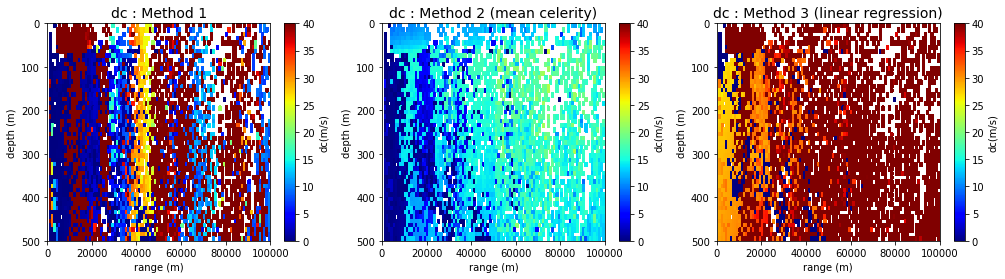

In [96]:
plt.figure(figsize=(17,4))
plt.subplot(131)
plt.pcolormesh(r, z, DC1_A[:,:,isd].T, cmap='jet')
plt.title ('dc : Method 1', fontsize=14)
plt.xlabel("range (m)")
plt.ylabel("depth (m)")
cbar = plt.colorbar()
cbar.set_label("dc(m/s)")
plt.clim ([0,40])
plt.gca().invert_yaxis()

plt.subplot(132)
plt.pcolormesh(r, z, DC2_A[:,:,isd].T, cmap='jet')
plt.title ('dc : Method 2 (mean celerity)', fontsize=14)
plt.xlabel("range (m)")
plt.ylabel("depth (m)")
cbar = plt.colorbar()
cbar.set_label("dc(m/s)")
plt.clim ([0,40])
plt.gca().invert_yaxis()

plt.subplot(133)
plt.pcolormesh(r, z, DC3_A[:,:,isd].T, cmap='jet')
plt.title ('dc : Method 3 (linear regression)', fontsize=14)
plt.xlabel("range (m)")
plt.ylabel("depth (m)")
cbar = plt.colorbar()
cbar.set_label("dc(m/s)")
plt.clim ([0,40])
plt.gca().invert_yaxis()

---
# Method 2 : pie chart

( Detection treshold method )


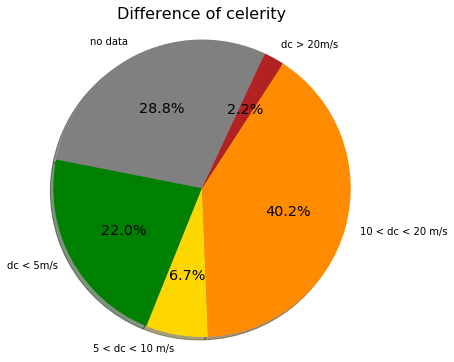

In [140]:
tot = np.shape(DC2_T)[0]*np.shape(DC2_T)[1]
nan = np.shape(np.where(np.isnan(DC2_T)))[1]
under5  = np.shape( np.where(DC2_T < 5)[0] )[0]
under10 = np.shape( np.where(np.logical_and(DC2_T>=5, DC2_T < 10))[0] )[0]
under20 = np.shape( np.where(np.logical_and(DC2_T>=10, DC2_T < 20))[0] )[0]
over20  = np.shape( np.where(DC2_T >= 20)[0] )[0]

name = ['no data','dc < 5m/s','5 < dc < 10 m/s', '10 < dc < 20 m/s', 'dc > 20m/s' ]
data = [nan, under5, under10, under20, over20]
plt.figure(figsize=(6,6))
patches, texts, autotexts = plt.pie(data, labels=name, colors=['grey','g','gold','darkorange','firebrick'], \
                                    autopct='%1.1f%%', startangle=65, shadow=True)  
for t in autotexts:
    t.set_color('k')
    t.set_size('x-large')
    
plt.axis('equal')
plt.title ('Difference of celerity', fontsize=16)
plt.show()